

# Sistema de Reconhecimento de Caracteres Braille usando CNN

## Trabalho Final - Processamento de Imagens
### Universidade do Vale do Itajaí - Ciência da Computação
#### Alunos: Gustavo Cadore, Lucas Pinheiro, Pedro Henrique, Samuel Cesario e David Smith

**Objetivo:** Desenvolver uma Rede Neural Convolucional (CNN) capaz de reconhecer caracteres Braille em imagens 28x28 pixels.

**Dataset:** 1.560 imagens de caracteres Braille (A-Z) com 3 tipos de augmentation cada.

---
## Instalação de Dependências

Instalação das bibliotecas necessárias:
- **TensorFlow**: Framework de deep learning para construir e treinar a CNN
- **OpenCV**: Biblioteca para processamento de imagens

**ATENÇÃO: Para executar o projeto, basta enviar o arquivo ZIP do material disponibilizado no GitHub do professor ou o ZIP incluído junto a este código nos arquivos da sessão do Colab, e então executar todas as células.**

In [2]:
!pip install tensorflow opencv-python gTTS


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 kB 5.3 MB/s eta 0:00:00
  Attempting uninstall: click
    Found existing installation: click 8.3.1
    Uninstalling click-8.3.1:
      Successfully uninstalled click-8.3.1


---
## Importação das Bibliotecas

Importando todas as bibliotecas necessárias para o projeto.

In [3]:

import numpy as np              # Operações numéricas e manipulação de arrays
# para manipular arquivos upados na sessão do collab
import os
import shutil
import zipfile

# Processamento de imagens
import cv2
from PIL import Image           # carregamento de imagens

# Machine Learning
from sklearn.model_selection import train_test_split  # Divisão treino/teste

# Deep Learning (TensorFlow/Keras)
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical

# Visualização
import matplotlib.pyplot as plt  # Plotagem de gráficos

#Text to speech
from gtts import gTTS
import IPython.display as ipd


print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.19.0


---
## Extração do Dataset

O dataset de caracteres Braille está compactado em um arquivo ZIP.
Nesta etapa, extraímos todas as imagens para uma pasta de trabalho.

In [5]:
# Configurar caminhos do dataset
caminho_arquivo = "/content/VielF ColabProjects main dataset-DatasetBraile_Option1.zip"
caminho_destino = "/content/"

# Criar pasta de destino se não existir
os.makedirs(caminho_destino, exist_ok=True)

# Extrair o arquivo ZIP
print("Extraindo dataset")
with zipfile.ZipFile(caminho_arquivo, 'r') as zip_ref:
    zip_ref.extractall(caminho_destino)

print(f"Dataset extraído para: {caminho_destino}")

Extraindo dataset
Dataset extraído para: /content/


---
##  Organização do Dataset por Classes

 As imagens do dataset estão soltas em uma única pasta.

 Organizamos as imagens em subpastas por classe (A, B, C, ..., Z).

**Estrutura final:**
```
dataset/
├── A/
│   ├── A_01_whs.png
│   ├── A_02_rot.png
│   └── ...
├── B/
│   ├── B_01_whs.png
│   └── ...
└── ...
```

Isso permite usar `image_dataset_from_directory()` do Keras, que automaticamente:
- Infere as labels pelos nomes das pastas
- Divide em treino/teste
- Cria batches automaticamente

In [6]:
# Definir caminhos
dataset_original = "/content/Braille Dataset/Braille Dataset"  # Pasta com imagens soltas
dataset_organizado = "/content/dataset"                         # Pasta organizada (saída)

# Criar diretório de saída
os.makedirs(dataset_organizado, exist_ok=True)

# Lista de classes: A-Z (26 letras do alfabeto)
CLASSES = [chr(i) for i in range(ord('A'), ord('Z') + 1)]
print(f"Classes: {CLASSES}")
print(f"Total de classes: {len(CLASSES)}\n")

# Criar subpasta para cada classe
for c in CLASSES:
    os.makedirs(os.path.join(dataset_organizado, c), exist_ok=True)

# Processar cada arquivo da pasta original
count = 0
for file in os.listdir(dataset_original):
    # Ignorar arquivos que não sejam imagens
    if not file.lower().endswith((".png", ".jpg", ".jpeg", ".bmp")):
        continue

    # Extrair a classe (primeira letra do nome do arquivo)
    # Exemplo: "A_01_rot.png" → classe = "A"
    label = file[0].upper()

    # Verificar se é uma classe válida (A-Z)
    if label in CLASSES:
        # Caminhos de origem e destino
        src = os.path.join(dataset_original, file)
        dst = os.path.join(dataset_organizado, label, file)

        # Copiar arquivo para a pasta correspondente
        shutil.copy(src, dst)
        count += 1

print(f"Dataset organizado com sucesso")
print(f"Total de imagens organizadas: {count}")
print(f"Estrutura criada em: {dataset_organizado}")

Classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
Total de classes: 26

Dataset organizado com sucesso
Total de imagens organizadas: 1560
Estrutura criada em: /content/dataset


---
##  Carregamento e Preparação dos Dados

Usando `image_dataset_from_directory()` para:
1. Carregar automaticamente as imagens das subpastas
2. Inferir labels pelos nomes das pastas
3. Dividir em treino (80%) e validação (20%)
4. Criar batches de 32 imagens
5. Converter para escala de cinza
6. Redimensionar para 28x28 pixels

**Usamos `seed=42` para garantir reprodutibilidade (mesma divisão treino/teste sempre).**

In [7]:
dataset_path = "/content/dataset"

# Carregar dataset de TREINO (80% dos dados)
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    labels="inferred",           # Labels inferidos pelos nomes das pastas
    label_mode="int",            # Labels como inteiros (0-25 para A-Z)
    color_mode="grayscale",      # Imagens em escala de cinza (1 canal)
    image_size=(28, 28),         # Redimensionar para 28x28 pixels
    batch_size=32,               # 32 imagens por batch
    validation_split=0.2,        # 20% para validação
    subset="training",           # Este é o conjunto de TREINO
    seed=42                      # Seed para reprodutibilidade
)

# Carregar dataset de VALIDAÇÃO/TESTE (20% dos dados)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    labels="inferred",
    label_mode="int",
    color_mode="grayscale",
    image_size=(28, 28),
    batch_size=32,
    validation_split=0.2,
    subset="validation",         # Este é o conjunto de VALIDAÇÃO
    seed=42
)

print("\n Datasets carregados com sucesso")

Found 1560 files belonging to 26 classes.
Using 1248 files for training.
Found 1560 files belonging to 26 classes.
Using 312 files for validation.

 Datasets carregados com sucesso


---
## Operações sem ML




**Imports, Configurações e Dicionário Braille**

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
import os
from pathlib import Path
from base64 import b64encode

# ---------- CONFIG ----------
DATASET_PATH = "/content/dataset"   # Ajuste para a pasta com subpastas A/, B/, ...
IMG_SIZE_STANDARD = (120, 180)      # (w,h) para normalizar a célula (proporção 2:3)
DOT_THRESHOLD_RATIO = 0.12          # proporção mínima de pixels brancos
PADDING = 8                          # padding no bbox
# ----------------------------

# ---------- DICIONÁRIO BRAILLE ----------
BRAILLE_MAP = {
    (1,0,0,0,0,0): 'A', (1,1,0,0,0,0): 'B', (1,0,0,1,0,0): 'C',
    (1,0,0,1,1,0): 'D', (1,0,0,0,1,0): 'E', (1,1,0,1,0,0): 'F',
    (1,1,0,1,1,0): 'G', (1,1,0,0,1,0): 'H', (0,1,0,1,0,0): 'I',
    (0,1,0,1,1,0): 'J', (1,0,1,0,0,0): 'K', (1,1,1,0,0,0): 'L',
    (1,0,1,1,0,0): 'M', (1,0,1,1,1,0): 'N', (1,0,1,0,1,0): 'O',
    (1,1,1,1,0,0): 'P', (1,1,1,1,1,0): 'Q', (1,1,1,0,1,0): 'R',
    (0,1,1,1,0,0): 'S', (0,1,1,1,1,0): 'T', (1,0,1,0,0,1): 'U',
    (1,1,1,0,0,1): 'V', (0,1,0,1,1,1): 'W', (1,0,1,1,0,1): 'X',
    (1,0,1,1,1,1): 'Y', (1,0,1,0,1,1): 'Z'
}


**Funções do Histograma (from-scratch)**

In [9]:
def calcular_histograma_scratch(img):
    """
    Percorre a imagem pixel a pixel e conta a frequência.
    Sem usar cv2.calcHist.
    """
    # Array de 256 posições (0 a 255) zerado
    hist = np.zeros(256, dtype=int)

    # img.ravel() transforma a matriz em uma linha única para o loop
    for pix in img.ravel():
        hist[pix] += 1

    return hist

def calcular_cdf_scratch(hist):
    """
    Calcula a soma acumulada (CDF) baseada no histograma.
    Sem usar numpy.cumsum.
    """
    cdf = np.zeros(256, dtype=int)
    acumulado = 0

    for i in range(256):
        acumulado += hist[i]
        cdf[i] = acumulado

    return cdf

**pré-processamento**

In [42]:

def center_crop_to_aspect(image, target_w=60, target_h=90):
    """
    Corta o centro da imagem para forçar a proporção correta (2:3)
    ANTES de redimensionar. Isso evita achatamento e evita bordas pretas.
    """
    h_orig, w_orig = image.shape[:2]

    # Proporção alvo (0.666...)
    target_aspect = target_w / target_h
    current_aspect = w_orig / h_orig

    if current_aspect > target_aspect:
        # Imagem muito larga (Paisagem) -> Cortar laterais
        new_w = int(h_orig * target_aspect)
        new_h = h_orig
        start_x = (w_orig - new_w) // 2
        # Realiza o corte (Crop)
        cropped = image[:, start_x : start_x + new_w]

    else:
        # Imagem muito alta (Retrato) -> Cortar topo e base
        new_w = w_orig
        new_h = int(w_orig / target_aspect)
        start_y = (h_orig - new_h) // 2
        # Realiza o corte (Crop)
        cropped = image[start_y : start_y + new_h, :]

    # Agora que a proporção está correta, podemos redimensionar sem distorcer
    final_img = cv2.resize(cropped, (target_w, target_h), interpolation=cv2.INTER_AREA)

    return final_img

def preprocess_final(path=None, img_array=None):
    # 1. Carregamento
    if path:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    else:
        img = img_array.copy()
        if img.ndim == 3: img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # 2. Recorte Inteligente (Center Crop)
    # Corta o excesso de papel para ficar na proporção 2:3 exata
    # Depois redimensiona para 60x90
    img_resized = center_crop_to_aspect(img, target_w=60, target_h=90)

    # 3. Caminho A: Máscara de Detecção (Otsu)
    # Como não temos mais barras pretas, o normalize funciona melhor
    img_norm = cv2.normalize(img_resized, None, 0, 255, cv2.NORM_MINMAX)

    # Blur leve
    blur = cv2.GaussianBlur(img_norm, (3,3), 0)

    # Threshold Otsu Invertido
    _, th = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Limpeza
    kernel = np.ones((3,3), np.uint8)
    mask = cv2.morphologyEx(th, cv2.MORPH_OPEN, kernel, iterations=1)

    # 4. Caminho B: Dados Matemáticos (Scratch)
    hist = calcular_histograma_scratch(img_resized)
    cdf = calcular_cdf_scratch(hist)

    return img_resized, mask, hist, cdf

**Encontrar Bounding Box da célula**

In [11]:
def encontrar_bbox_celula(mask):
    ys, xs = np.where(mask == 255)
    if ys.size == 0:
        h, w = mask.shape
        return 0, 0, w, h

    y1, y2 = ys.min(), ys.max()
    x1, x2 = xs.min(), xs.max()

    y1 = max(0, y1 - PADDING)
    x1 = max(0, x1 - PADDING)
    y2 = min(mask.shape[0], y2 + PADDING)
    x2 = min(mask.shape[1], x2 + PADDING)

    return x1, y1, x2, y2

**Lógica 3×2 (detecção dos pontos)**

In [45]:
def matriz_3x2_fixed_grid(mask, debug=False):
    h, w = mask.shape
    dy = h // 3
    dx = w // 2

    # Vamos guardar os resultados numa matriz temporária 3x2
    # para ficar fácil de desenhar e organizar
    grid_matrix = np.zeros((3, 2), dtype=int)
    stats = []

    debug_img = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
    THRESHOLD_AREA = 0.10

    # Loop visual (Linha por Linha) - Mantemos assim para desenhar correto
    for row in range(3):
        for col in range(2):
            y1, y2 = row * dy, (row + 1) * dy
            x1, x2 = col * dx, (col + 1) * dx

            crop_cell = mask[y1:y2, x1:x2]

            total = crop_cell.size
            brancos = np.count_nonzero(crop_cell)
            ratio = brancos / total

            is_dot = 1 if ratio > THRESHOLD_AREA else 0

            # Salva na matriz
            grid_matrix[row, col] = is_dot
            stats.append((row, col, ratio, is_dot))

            # Desenho Debug
            color = (0, 255, 0) if is_dot else (0, 0, 255)
            cv2.rectangle(debug_img, (x1, y1), (x2, y2), (255, 0, 0), 1)
            cx, cy = x1 + dx//2, y1 + dy//2
            cv2.circle(debug_img, (cx, cy), 5, color, -1)

    # --- CORREÇÃO CRUCIAL ---
    # Agora transformamos a matriz em Tupla na ordem VERTICAL (Braille Padrão)
    # Primeiro os 3 da esquerda (Col 0), depois os 3 da direita (Col 1)
    col_esq = grid_matrix[:, 0] # [Linha0, Linha1, Linha2] da coluna 0
    col_dir = grid_matrix[:, 1] # [Linha0, Linha1, Linha2] da coluna 1

    # Concatena: (1, 2, 3, 4, 5, 6)
    bits = list(col_esq) + list(col_dir)

    return tuple(bits), stats, debug_img

**Mapeamento para Letra**

In [13]:
def bits_to_letter(bits_tuple):
    return BRAILLE_MAP.get(bits_tuple, '?')

**Desenho das Anotações**

In [14]:
def desenhar_anotacoes(img, bbox, stats, crop_resized):
    """
    Adiciona anotações da bounding box e dos pontos detectados.
    stats contém tuplas: (row, col, ratio, present)
    """
    img_color = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

    if bbox is not None:
        x1, y1, x2, y2 = bbox
        cv2.rectangle(img_color, (x1, y1), (x2, y2), (0,255,0), 2)

    # Desenhar os pontos detectados
    h_crop, w_crop = crop_resized.shape[:2]

    # Para cada célula (row,col)
    for row, col, ratio, present in stats:
        # posição aproximada dentro do crop
        cy = int(((row + 0.5) / 3) * (y2 - y1)) + y1
        cx = int(((col + 0.5) / 2) * (x2 - x1)) + x1

        color = (0,255,0) if present == 1 else (0,0,255)
        cv2.circle(img_color, (cx, cy), 6, color, -1)

    return img_color


**Pipeline Completo para UMA imagem**

In [27]:
LETTER_TO_BITS = {v: k for k, v in BRAILLE_MAP.items()}

def pipeline_single_image(path=None, img_array=None, show_plots=True, falar=False):
    path = str(path) if path else None

    # 1. Processa
    orig, mask, hist, cdf = preprocess_final(path, img_array)

    # 2. Detecta
    bits_tuple, stats, grid_visual = matriz_3x2_fixed_grid(mask)
    letra_pred = bits_to_letter(bits_tuple)

    # 3. Acurácia Soft
    true_label = "?"
    if path:
        # Tenta pegar o nome da pasta pai
        try:
            parent = os.path.basename(os.path.dirname(path))
            if len(parent) == 1:
                true_label = parent.upper()
        except:
            true_label = "?"

    acc_soft = 0.0
    true_bits = LETTER_TO_BITS.get(true_label)
    if true_bits:
        acertos = sum([1 for pb, tb in zip(bits_tuple, true_bits) if pb == tb])
        acc_soft = acertos / 6.0

    # 4. Exibição Visual
    if show_plots:
        plt.figure(figsize=(15, 8))

        # --- LINHA 1 ---
        plt.subplot(2, 3, 1); plt.imshow(orig, cmap='gray'); plt.title("Imagem Original"); plt.axis('off')
        plt.subplot(2, 3, 2); plt.imshow(mask, cmap='gray'); plt.title("Máscara (Otsu)"); plt.axis('off')

        plt.subplot(2, 3, 3); plt.imshow(grid_visual)
        c = 'green' if true_label == letra_pred else 'blue'
        plt.title(f"Pred: {letra_pred} | Real: {true_label}\nAcc Pts: {acc_soft*100:.0f}%", color=c, fontweight='bold'); plt.axis('off')

        # --- LINHA 2 (Gráficos Matemáticos) ---
        ax_hist = plt.subplot(2, 3, 4)
        ax_hist.bar(range(256), hist, color='green', label='Freq'); ax_hist.set_title("Histograma (Scratch)")
        ax_cdf = ax_hist.twinx()
        ax_cdf.plot(cdf, color='blue', linewidth=2, label='CDF'); ax_cdf.set_yticks([])

        # Matriz Digital
        plt.subplot(2, 3, 6)
        mat = np.array(bits_tuple).reshape(3, 2, order='F')
        plt.imshow(mat, cmap='Blues', vmin=0, vmax=1)
        for i in range(3):
            for j in range(2):
                val = mat[i, j]
                txt_c = 'white' if val==1 else 'black'
                if true_bits: txt_c = 'lime' if val == true_bits[i + j*3] else 'red'
                plt.text(j, i, str(val), ha='center', va='center', color=txt_c, fontsize=20, fontweight='bold')
        plt.title("Matriz Digital"); plt.axis('off')

        plt.tight_layout(); plt.show()

        # Texto no Console
        print("\n" + "="*60)
        print(f"RELATÓRIO: {os.path.basename(path) if path else 'Memória'}")
        print(f"Predição: {letra_pred} | Gabarito: {true_label}")
        print("="*60 + "\n")

    # 5. VOZ
    if falar and letra_pred != "?" and letra_pred is not None:
        try:
            texto_falado = f"A letra é {letra_pred}"
            tts = gTTS(text=texto_falado, lang='pt')
            arquivo_audio = "voz_letra_scratch.mp3"
            tts.save(arquivo_audio)
            print(f"🔊 Falando: {texto_falado}")
            ipd.display(ipd.Audio(arquivo_audio, autoplay=True))
        except Exception as e:
            print(f"Erro ao gerar áudio: {e}")

    # --- CORREÇÃO AQUI: Adicionei 'true' de volta ao dicionário ---
    return {
        "pred": letra_pred,
        "true": true_label,
        "acc": acc_soft,
        "bits": bits_tuple
    }

**Função para imagem aleatória do Dataset**

In [16]:
def random_image_from_dataset(dataset_path=DATASET_PATH):
    classes = sorted([d.name for d in Path(dataset_path).iterdir() if d.is_dir()])
    cls = random.choice(classes)
    files = list((Path(dataset_path)/cls).glob("*"))
    f = random.choice(files)
    return str(f), cls


**Função da Webcam**

In [32]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
import cv2
import numpy as np

def take_photo(filename='photo.jpg', quality=0.8):
  """
  Função mágica que injeta JavaScript no navegador para abrir a webcam
  e salvar um frame como arquivo no Colab.
  """
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = '📸 TIRAR FOTO';
      div.style.marginBottom = '10px';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Redimensiona o output para caber o vídeo
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Espera o clique no botão
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])

  with open(filename, 'wb') as f:
    f.write(binary)
  return filename


def capture_from_webcam_and_run(show_plots=True, falar=True):
    print("Prepare o Braille na frente da câmera e clique em '📸 TIRAR FOTO'...")

    try:
        # 1. Tira a foto usando o JavaScript
        filename = take_photo('photo.jpg')
        print('Foto capturada com sucesso! Processando...')

        # 2. Roda o seu pipeline existente
        # Passamos o caminho do arquivo (filename) diretamente
        return pipeline_single_image(path=filename, show_plots=show_plots, falar=falar)

    except Exception as e:
        # Geralmente cai aqui se o usuário cancelar ou não der permissão de câmera
        print(f"Captura cancelada ou erro: {str(e)}")
        return None

**Função para imagem escolhida a dedo (para fins de comparação)**

In [25]:
def run_from_manual_path(path, show_plots=True):
    """
    Executa o pipeline_single_image() com uma imagem escolhida pelo usuário.
    Igual ao random e ao webcam.
    """
    from pathlib import Path
    import cv2

    print("\n" + "="*80)
    print("[IMAGEM ESCOLHIDA MANUALMENTE]")
    print("Caminho:", path)
    print("="*80 + "\n")

    # Se a imagem estiver no dataset, tenta inferir a classe verdadeira
    true_class = None
    p = Path(path)

    if p.parent.name.isalpha() and len(p.parent.name) == 1:
        true_class = p.parent.name.upper()

    # Se quiser forçar leitura, pode usar img_array
    return pipeline_single_image(path=path, show_plots=True, falar=True)

**Execução (random + webcam opcional)**

Imagem aleatória: /content/dataset/C/c1.JPG15dim.jpg


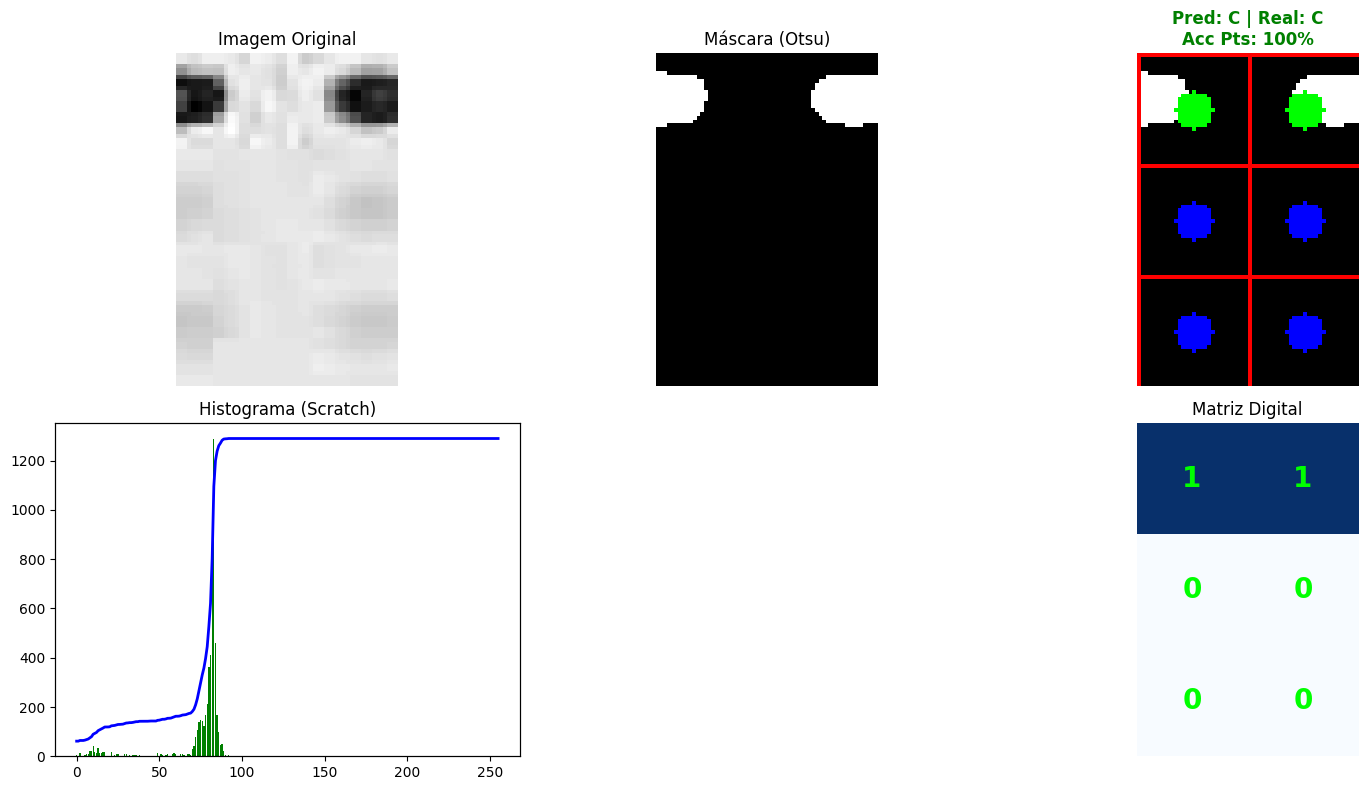


RELATÓRIO: c1.JPG15dim.jpg
Predição: C | Gabarito: C

🔊 Falando: A letra é C


Pred: C | True: C | ACC: 1.0

[IMAGEM ESCOLHIDA MANUALMENTE]
Caminho: /content/dataset/A/a1.JPG9dim.jpg



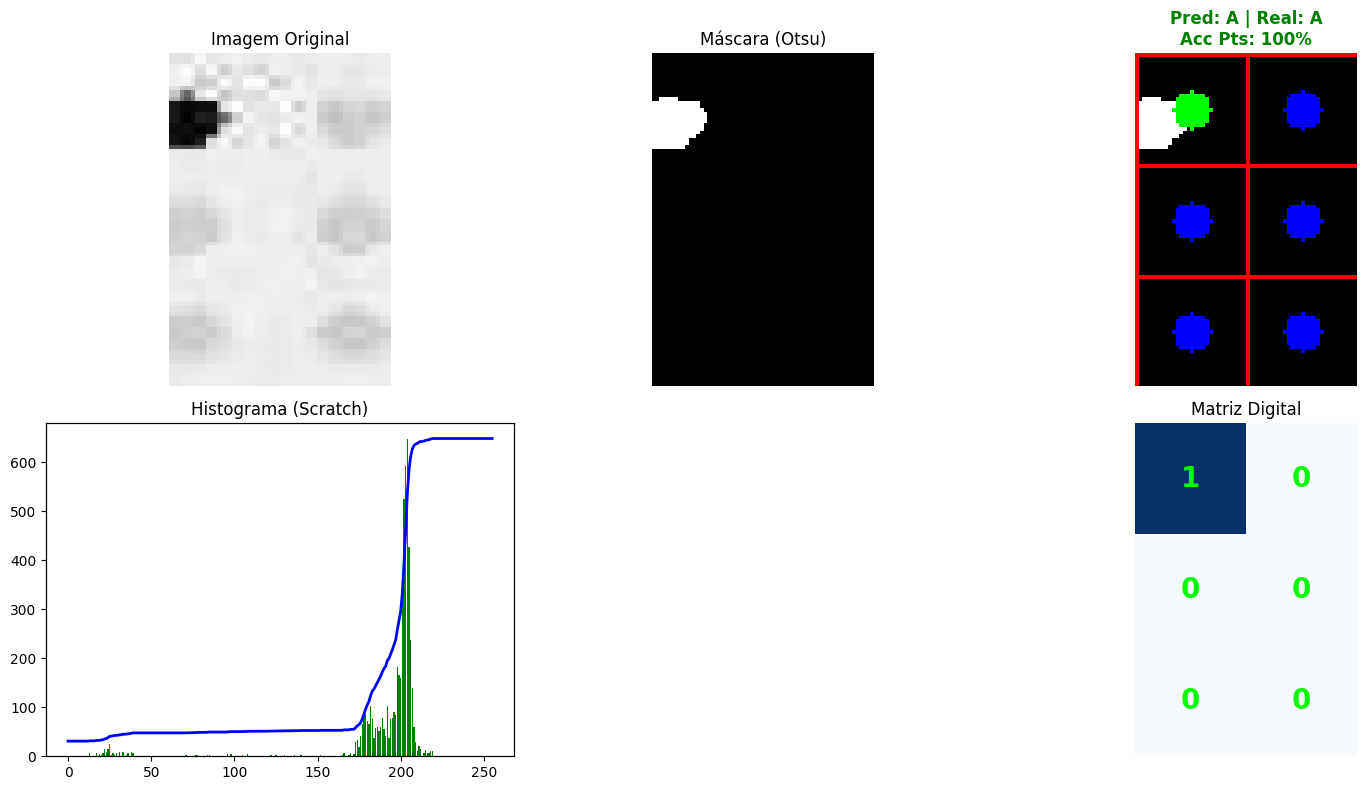


RELATÓRIO: a1.JPG9dim.jpg
Predição: A | Gabarito: A

🔊 Falando: A letra é A


Pred: A | True: A | ACC: 1.0
Prepare o Braille na frente da câmera e clique em '📸 TIRAR FOTO'...


<IPython.core.display.Javascript object>

Foto capturada com sucesso! Processando...


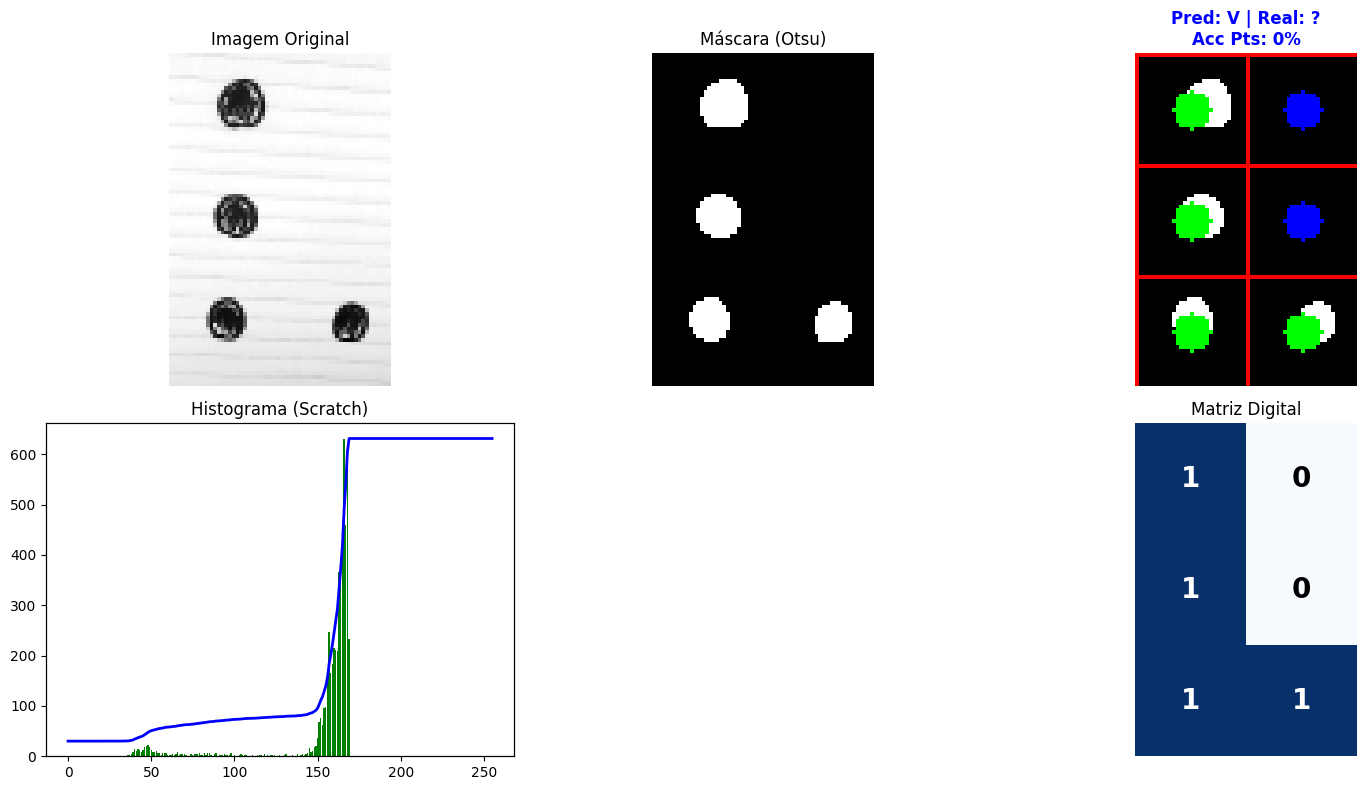


RELATÓRIO: photo.jpg
Predição: V | Gabarito: ?

🔊 Falando: A letra é V


Pred: V | True: ? | ACC: 0.0


In [46]:
try:
    img_path, img_class = random_image_from_dataset(DATASET_PATH)
    print("Imagem aleatória:", img_path)
    res = pipeline_single_image(path=img_path, show_plots=True, falar=True)
    print("Pred:", res['pred'], "| True:", res['true'], "| ACC:", res['acc'])
    res2 = run_from_manual_path("/content/dataset/A/a1.JPG9dim.jpg")
    print("Pred:", res2['pred'], "| True:", res2['true'], "| ACC:", res2['acc'])
    res3 = capture_from_webcam_and_run(show_plots=True, falar=True)
    print("Pred:", res3['pred'], "| True:", res3['true'], "| ACC:", res3['acc'])
except Exception as e:
    print("Erro:", e)

**Avaliar dataset completo**

Iniciando avaliação completa em: /content/dataset...

✅ Classe 'A' processada.
✅ Classe 'B' processada.
✅ Classe 'C' processada.
✅ Classe 'D' processada.
✅ Classe 'E' processada.
✅ Classe 'F' processada.
✅ Classe 'G' processada.
✅ Classe 'H' processada.
✅ Classe 'I' processada.
✅ Classe 'J' processada.
✅ Classe 'K' processada.
✅ Classe 'L' processada.
✅ Classe 'M' processada.
✅ Classe 'N' processada.
✅ Classe 'O' processada.
✅ Classe 'P' processada.
✅ Classe 'Q' processada.
✅ Classe 'R' processada.
✅ Classe 'S' processada.
✅ Classe 'T' processada.
✅ Classe 'U' processada.
✅ Classe 'V' processada.
✅ Classe 'W' processada.
✅ Classe 'X' processada.
✅ Classe 'Y' processada.
✅ Classe 'Z' processada.

RELATÓRIO DE AVALIAÇÃO (Lógica Sem ML)
Total de Imagens: 1560
Tempo de Execução: 4.85 segundos
--------------------------------------------------
ACURÁCIA DE LETRA (Hard):  54.04%
--------------------------------------------------
ACURÁCIA DE PONTOS (Soft): 82.18%

Gerando Matriz de Confusão...

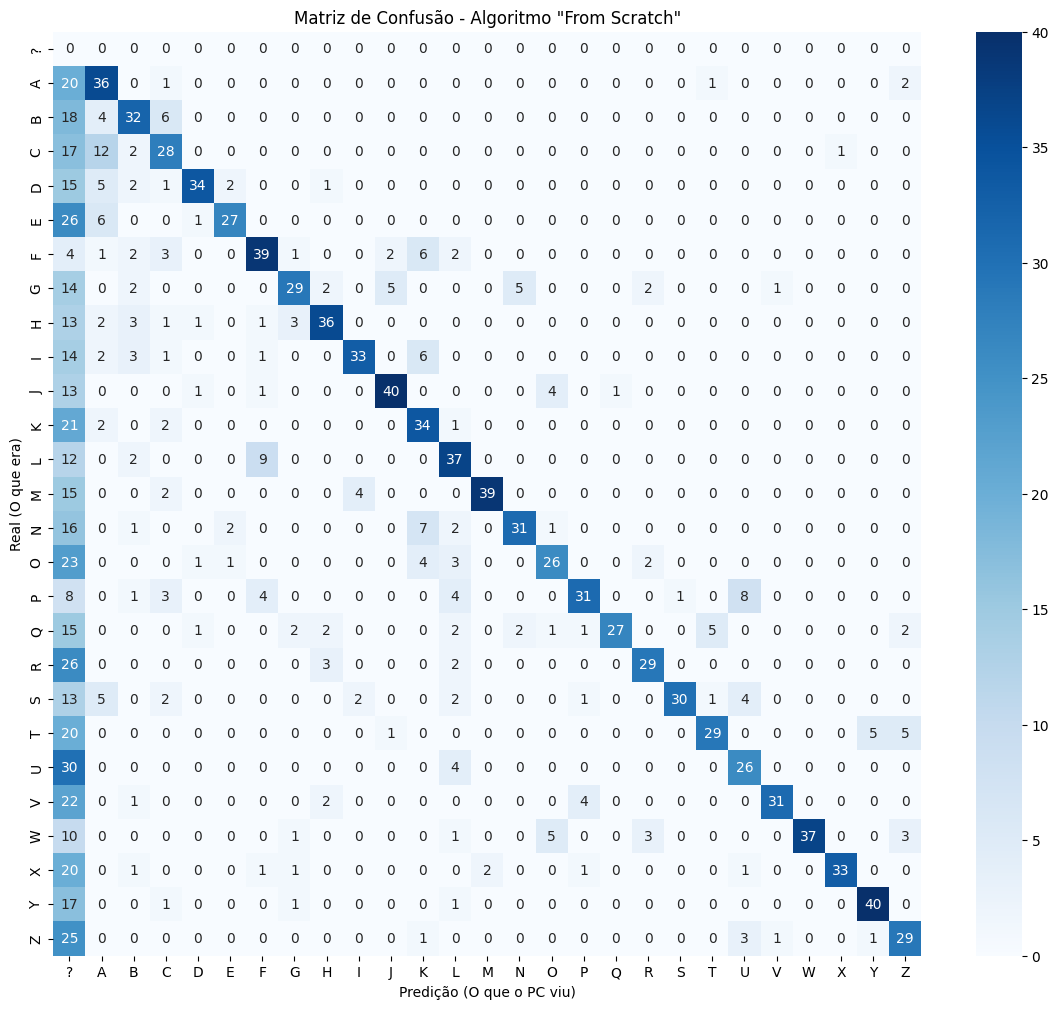

In [47]:
import os
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 1. Criar o Dicionário Reverso (Letra -> Tupla)
# Ex: 'A': (1,0,0,0,0,0)
LETTER_TO_BITS = {v: k for k, v in BRAILLE_MAP.items()}

def calcular_acuracia_pontos(pred_bits, true_bits):
    """Compara duas tuplas de 6 bits e retorna a % de igualdade."""
    if not true_bits or not pred_bits:
        return 0.0

    acertos = 0
    for p, t in zip(pred_bits, true_bits):
        if p == t:
            acertos += 1
    return acertos / 6.0  # Retorna valor entre 0.0 e 1.0

def avaliar_dataset_completo(dataset_path="/content/dataset"):
    print(f"Iniciando avaliação completa em: {dataset_path}...\n")

    total_imagens = 0

    # Métricas
    acertos_letras = 0    # Acertou a letra em cheio
    soma_acuracia_pontos = 0.0 # Soma das % de cada imagem

    # Listas para Matriz de Confusão
    y_true = []
    y_pred = []

    start_time = time.time()

    # Percorrer pastas A, B, C...
    # Filtra apenas pastas que são letras (len==1)
    classes_ordenadas = sorted([d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d)) and len(d) == 1])

    for classe in classes_ordenadas:
        pasta_classe = os.path.join(dataset_path, classe)

        # Pega a tupla gabarito (Ground Truth)
        true_bits = LETTER_TO_BITS.get(classe.upper())
        if true_bits is None:
            continue

        arquivos = os.listdir(pasta_classe)

        for arquivo in arquivos:
            caminho_img = os.path.join(pasta_classe, arquivo)

            # Filtra apenas imagens para evitar erros
            if not arquivo.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
                continue

            try:
                # 1. Roda o Pipeline (sem mostrar plots pra ser rápido)
                resultado = pipeline_single_image(path=caminho_img, show_plots=False)

                pred_letra = resultado['pred']
                pred_bits = resultado['bits']

                # 2. Guarda dados para Matriz de Confusão
                y_true.append(classe.upper())
                y_pred.append(pred_letra)

                # 3. Contabiliza Letra (Tudo ou Nada)
                if pred_letra == classe.upper():
                    acertos_letras += 1

                # 4. Contabiliza Pontos (Bit a Bit)
                acc_pontos = calcular_acuracia_pontos(pred_bits, true_bits)
                soma_acuracia_pontos += acc_pontos

                total_imagens += 1

            except Exception as e:
                pass # Ignora erros pontuais de leitura

        # Feedback visual a cada classe processada
        print(f"✅ Classe '{classe}' processada.")

    # --- RELATÓRIO FINAL EM TEXTO ---
    tempo_total = time.time() - start_time

    if total_imagens == 0:
        print("Nenhuma imagem encontrada.")
        return

    acc_final_letras = (acertos_letras / total_imagens) * 100
    acc_final_pontos = (soma_acuracia_pontos / total_imagens) * 100

    print("\n" + "="*50)
    print("RELATÓRIO DE AVALIAÇÃO (Lógica Sem ML)")
    print("="*50)
    print(f"Total de Imagens: {total_imagens}")
    print(f"Tempo de Execução: {tempo_total:.2f} segundos")
    print("-" * 50)
    print(f"ACURÁCIA DE LETRA (Hard):  {acc_final_letras:.2f}%")
    print("-" * 50)
    print(f"ACURÁCIA DE PONTOS (Soft): {acc_final_pontos:.2f}%")
    print("="*50)

    # --- GERAÇÃO DA MATRIZ DE CONFUSÃO ---
    print("\nGerando Matriz de Confusão...")

    # Define labels dinamicamente (inclui '?' se houver erro de predição)
    labels_unicos = sorted(list(set(y_true + y_pred)))

    cm = confusion_matrix(y_true, y_pred, labels=labels_unicos)

    plt.figure(figsize=(14, 12))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels_unicos, yticklabels=labels_unicos)

    plt.title('Matriz de Confusão - Algoritmo "From Scratch"')
    plt.xlabel('Predição (O que o PC viu)')
    plt.ylabel('Real (O que era)')
    plt.show()

# Executar a avaliação completa
avaliar_dataset_completo()

---
## Construção do Modelo CNN

### Arquitetura da Rede Neural Convolucional:

**Camada de Entrada:**
- `Rescaling(1./255)`: Normaliza pixels de [0, 255] para [0, 1]

**Bloco Convolucional 1:**
- `Conv2D(32)`: Extrai 32 features básicas (bordas, pontos)
- `MaxPooling2D`: Reduz dimensionalidade (26x26 → 13x13)

**Bloco Convolucional 2:**
- `Conv2D(64)`: Extrai 64 features mais complexas
- `MaxPooling2D`: Reduz dimensionalidade (11x11 → 5x5)

**Camadas Densas (Fully Connected):**
- `Flatten`: Converte matriz 5x5x64 em vetor 1D (1600 valores)
- `Dense(128)`: Camada oculta com 128 neurônios
- `Dense(26, softmax)`: Camada de saída com 26 neurônios (A-Z)


**Caso queira carregar o modelo treinado durante a produção do trabalho, basta executar a célula a seguir. Se preferir treinar um modelo do zero usando o dataset, basta ignorar ela e ir para a próxima célula**

In [ ]:
from keras.models import load_model

model = load_model("braille_cnn_model-Treinado.keras")


In [ ]:
# Número de classes (26 letras: A-Z)
NUM_CLASSES = 26

# Construir o modelo Sequential (camadas empilhadas sequencialmente)
model = models.Sequential([

    # CAMADA DE NORMALIZAÇÃO
    # Converte pixels de [0, 255] para [0, 1] para melhor convergência
    layers.Rescaling(1./255, input_shape=(28, 28, 1)),

    # BLOCO CONVOLUCIONAL 1
    # Conv2D: Aplica 32 filtros 3x3 para detectar features básicas
    # ReLU: Função de ativação (remove valores negativos)
    layers.Conv2D(32, (3, 3), activation='relu'),
    # MaxPooling: Reduz dimensionalidade pegando o máximo de cada região 2x2
    layers.MaxPooling2D((2, 2)),

    # BLOCO CONVOLUCIONAL 2
    # Conv2D: Aplica 64 filtros 3x3 para detectar features mais complexas
    layers.Conv2D(64, (3, 3), activation='relu'),
    # MaxPooling: Nova redução de dimensionalidade
    layers.MaxPooling2D((2, 2)),

    # CAMADAS DENSAS (CLASSIFICAÇÃO)
    # Flatten: Transforma matriz em vetor 1D
    layers.Flatten(),
    # Dense: Camada totalmente conectada com 128 neurônios
    layers.Dense(128, activation='relu'),
    # Dense: Camada de saída com 26 neurônios (um para cada letra)
    # Softmax: Converte saídas em probabilidades que somam 1
    layers.Dense(NUM_CLASSES, activation='softmax')
], name='BrailleCNN')

print("Modelo criado \n")
model.summary()

Modelo criado 



/usr/local/lib/python3.12/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "BrailleCNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 26)             │         3,354 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 227,098 (887.10 KB)

 Trainable params: 227,098 (887.10 KB)

 Non-trainable params: 0 (0.00 B)

---
##  Compilação do Modelo

Configurando os componentes necessários para o treinamento:

**Função de Perda (sparse_categorical_crossentropy):**
- Mede o quão errado o modelo está
- "sparse" porque os labels são inteiros (0-25), não one-hot encoded

In [ ]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',     # Função de perda para classificação
    metrics=['accuracy']                        # Métrica de avaliação
)

print("Modelo compilado e pronto para treinar")

Modelo compilado e pronto para treinar


---
## Treinamento do Modelo


In [ ]:
# Número de épocas (quantas vezes o modelo verá todo o dataset)
EPOCHS = 15

print("Iniciando treinamento\n")

# Treinar o modelo
history = model.fit(
    train_ds,                    # Dataset de treino
    epochs=EPOCHS,               # Número de épocas
    validation_data=test_ds,     # Dataset de validação
    verbose=1                    # Mostrar progresso detalhado
)

print("\n✓ Treinamento concluído!")

Iniciando treinamento

Epoch 1/15
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 79ms/step - accuracy: 0.0473 - loss: 3.2561 - val_accuracy: 0.1058 - val_loss: 3.0651
Epoch 2/15
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.2535 - loss: 2.6981 - val_accuracy: 0.5417 - val_loss: 1.7578
Epoch 3/15
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.5875 - loss: 1.5899 - val_accuracy: 0.6346 - val_loss: 1.4247
Epoch 4/15
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.6509 - loss: 1.2721 - val_accuracy: 0.6506 - val_loss: 1.2713
Epoch 5/15
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.7009 - loss: 1.0675 - val_accuracy: 0.6859 - val_loss: 1.1167
Epoch 6/15
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.7353 - loss: 0.9165 - val_accuracy: 0.6795 - val_loss: 1.0832
Epoch 7/15
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.7816 - loss: 0.7419 - val_accuracy: 0.7115 - val_loss: 1.0139
Epoch 8/15
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.8334 - loss: 0.5878 - v

---
##  Avaliação do Modelo

**Meta do trabalho:** ≥ 75% de acurácia no teste

In [ ]:
# Avaliar o modelo no conjunto de teste
loss, acc = model.evaluate(test_ds)

print(f"RESULTADO FINAL NO TESTE")
print(f"{'-'*25}")
print(f"  Loss (Perda): {loss:.4f}")
print(f"  Acurácia: {acc*100:.2f}%")


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7441 - loss: 1.2022
RESULTADO FINAL NO TESTE
-------------------------
  Loss (Perda): 1.0121
  Acurácia: 78.85%


---
##  Salvamento do Modelo

Salvando o modelo treinado para uso posterior.

**Formato `.keras`:**
- Formato recomendado pelo TensorFlow 2.x
- Salva arquitetura + pesos + configuração de treinamento
- Pode ser carregado depois com: `keras.models.load_model('braille_cnn_model.keras')`

In [ ]:
# Salvar modelo completo
model.save("braille_cnn_model.keras")

print(" Modelo salvo como: braille_cnn_model.keras")
print("\nPara carregar novamente:")
print("  model = keras.models.load_model('braille_cnn_model.keras')")

 Modelo salvo como: braille_cnn_model.keras

Para carregar novamente:
  model = keras.models.load_model('braille_cnn_model.keras')


---
## Teste com Imagem Aleatória do Dataset

Vamos testar o modelo com uma imagem aleatória do conjunto de teste para ver como ele se comporta.


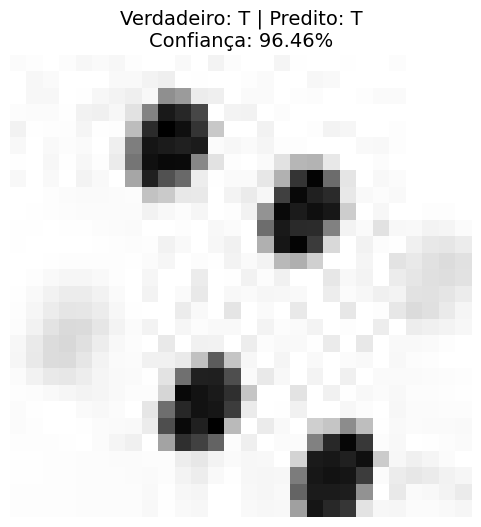


 Resultado da Predição:
  Letra verdadeira: T
  Letra predita: T
  Confiança: 96.46%
  Status: CORRETO


In [ ]:
# Lista de classes (A-Z)
CLASSES = [chr(ord('A') + i) for i in range(26)]

# ========================================
# Selecionar uma imagem aleatória
# ========================================

# Pegar o primeiro batch do dataset de teste
for images, labels in test_ds.take(1):
    pass  # Apenas pega o batch e sai do loop

# Sortear um índice aleatório dentro do batch
idx = np.random.randint(0, images.shape[0])

# Extrair a imagem e o label verdadeiro
img = images[idx].numpy()           # Imagem selecionada
true_label = labels[idx].numpy()    # Label verdadeiro (número 0-25)

# Preparar imagem para predição (adicionar dimensão do batch)
img_input = np.expand_dims(img, axis=0)  # Shape: (1, 28, 28, 1)


# Fazer predição

pred = model.predict(img_input, verbose=0)  # Predição (probabilidades)
pred_idx = np.argmax(pred)                  # Índice da classe com maior probabilidade
pred_letra = CLASSES[pred_idx]             # Letra predita
letra_real = CLASSES[true_label]           # Letra verdadeira
confidence = np.max(pred)                   # Confiança da predição]


# Visualizar resultado

plt.figure(figsize=(6, 6))
plt.imshow(img.squeeze(), cmap="gray")
plt.title(
    f"Verdadeiro: {letra_real} | Predito: {pred_letra}\nConfiança: {confidence*100:.2f}%",
    fontsize=14
)
plt.axis("off")
plt.show()

# Mostrar resultado
print(f"\n Resultado da Predição:")
print(f"  Letra verdadeira: {letra_real}")
print(f"  Letra predita: {pred_letra}")
print(f"  Confiança: {confidence*100:.2f}%")
print(f"  Status: {'CORRETO' if pred_letra == letra_real else 'INCORRETO'}")
 # TEXT TO SPEECH (Ler a letra predita)
tts = gTTS(text=pred_letra, lang='pt')
tts.save("voz_letra.mp3")
ipd.display(ipd.Audio("voz_letra.mp3", autoplay=True))

---
## Inferência com Upload de Imagem

Permite fazer upload de uma imagem externa e obter a predição do modelo.

### Requisitos da Imagem:
- Formato: PNG, JPG, JPEG, BMP

### Pré-processamento Aplicado:
1. Conversão para escala de cinza
2. Redimensionamento para 28x28 pixels
3.  Não normalizar manualmente (o modelo já tem camada Rescaling)

In [ ]:
from google.colab import files
from PIL import Image

# Lista de classes (A-Z)
CLASSES = [chr(ord('A') + i) for i in range(26)]

#  Upload da Imagem

print("Faça upload de uma imagem de caractere Braille:")
uploaded = files.upload()

if uploaded:
    nomearquivo = list(uploaded.keys())[0]
    print(f"\n Arquivo recebido: {nomearquivo}")

    # Pré-processamento da Imagem

    # Carregar imagem e converter para escala de cinza
    img = Image.open(nomearquivo).convert("L")

    # Redimensionar para 28x28 pixels (tamanho usado no treinamento)
    img = img.resize((28, 28))

    # Converter para array NumPy
    img_array = np.array(img)

    # Adicionar dimensões para batch e canal
    # Shape final: (1, 28, 28, 1) = (batch, altura, largura, canais)
    img_input = np.expand_dims(img_array, axis=(0, -1))

    print(f"  Shape processado: {img_input.shape}")
    print(f"  Range de valores: [{img_input.min()}, {img_input.max()}]")

    # Predição

    print("\nFazendo predição")
    pred = model.predict(img_input, verbose=0)
    pred_idx = np.argmax(pred)              # Índice da classe predita
    pred_letra = CLASSES[pred_idx]         # Letra predita
    confianca = pred[0][pred_idx]          # Confiança da predição

    # Visualização do Resultado

    plt.figure(figsize=(8, 6))
    plt.imshow(img_array, cmap="gray")
    plt.title(f"Predição: {pred_letra}\nConfiança: {confianca*100:.2f}%", fontsize=16)
    plt.axis("off")
    plt.show()

    # Mostrar resultado principal
    print(f" RESULTADO DA INFERÊNCIA")
    print(f"{'-'*25}")
    print(f"  Letra predita: {pred_letra}")
    print(f"  Confiança: {confianca*100:.2f}%")
    print(f"{'-'*25}")
    # TEXT TO SPEECH (Ler a letra predita)
    tts = gTTS(text=pred_letra, lang='pt')
    tts.save("voz_letra.mp3")
    ipd.display(ipd.Audio("voz_letra.mp3", autoplay=True))


    # 5. Top-3 Predições (para análise)

    print(f"\nTop 3 Predições:")
    top3_idx = np.argsort(pred[0])[-3:][::-1]  # 3 maiores probabilidades
    for i, idx in enumerate(top3_idx, 1):
        letra = CLASSES[idx]
        prob = pred[0][idx] * 100
        barra = "█" * int(prob / 5)  # Barra visual
        print(f"  {i}. {letra}: {prob:5.2f}% {barra}")

    # Alertas de baixa confiança
    if confianca < 0.5:
        print(f"\n AVISO: Confiança muito baixa (<50%)")
        print(f"   Possíveis causas:")
        print(f"   - Imagem com qualidade ruim")
        print(f"   - Caractere diferente do dataset de treino")
        print(f"   - Imagem muito diferente (fundo, iluminação, etc)")

else:
    print("\n Nenhum arquivo foi enviado.")

Faça upload de uma imagem de caractere Braille:


KeyboardInterrupt: 

---
## Inferência com Foto registrada pela camera do usuario

Permite tirar uma foto e enviar para o modelo fazer a inferencia

### Pré-processamento Aplicado:
1. Conversão para escala de cinza
2. Redimensionamento para 28x28 pixels
3.  Não normalizar manualmente (o modelo já tem camada Rescaling)

In [ ]:
from IPython.display import display, Javascript, Image as IPImage
from google.colab.output import eval_js
from base64 import b64decode
from PIL import Image
import io

def take_photo(filename='photo.jpg', quality=0.9):
    js = Javascript('''
        async function main(quality) {
            const div = document.createElement('div');
            const video = document.createElement('video');
            const button = document.createElement('button');

            div.style = 'display: flex; flex-direction: column; align-items: center;';
            button.textContent = '📸 Capturar Foto';
            button.style = 'margin-top: 10px; padding: 10px 20px; font-size: 16px;';

            div.appendChild(video);
            div.appendChild(button);
            document.body.appendChild(div);

            const stream = await navigator.mediaDevices.getUserMedia({video: true});
            video.srcObject = stream;
            await video.play();

            // Espera clique do usuário
            await new Promise(resolve => button.onclick = resolve);

            // Faz captura do frame
            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);

            // Para câmera
            stream.getVideoTracks()[0].stop();

            // Remove elementos
            div.remove();

            return canvas.toDataURL('image/jpeg', quality);
        }
    ''')
    display(js)

    data = eval_js(f'main({quality})')
    binary = b64decode(data.split(',')[1])

    with open(filename, 'wb') as f:
        f.write(binary)

    return filename


<IPython.core.display.Javascript object>

 Imagem capturada: captured_image.jpg
Shape: (1, 28, 28, 1)
Range: [3, 226]


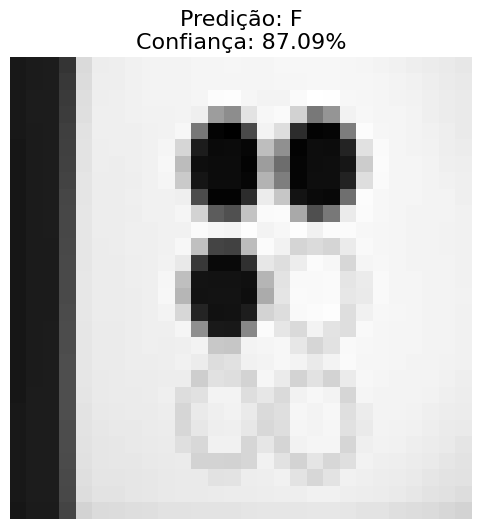


RESULTADO
------------------------------
Letra predita: F
Confiança: 87.09%
------------------------------


In [ ]:


try:
    filename = take_photo('captured_image.jpg')
    print(f" Imagem capturada: {filename}")

    # Pré-processamento
    img = Image.open(filename).convert("L")
    img = img.resize((28, 28))
    img_array = np.array(img)
    img_input = np.expand_dims(img_array, axis=(0, -1))

    print(f"Shape: {img_input.shape}")
    print(f"Range: [{img_input.min()}, {img_input.max()}]")

    # Predição
    pred = model.predict(img_input, verbose=0)
    pred_idx = np.argmax(pred)
    pred_letra = CLASSES[pred_idx]
    confianca = pred[0][pred_idx]

    # Visualização
    plt.figure(figsize=(8, 6))
    plt.imshow(img_array, cmap="gray")
    plt.title(f"Predição: {pred_letra}\nConfiança: {confianca*100:.2f}%", fontsize=16)
    plt.axis("off")
    plt.show()

    print("\nRESULTADO")
    print("-"*30)
    print(f"Letra predita: {pred_letra}")
    print(f"Confiança: {confianca*100:.2f}%")
    print("-"*30)

    # TEXT TO SPEECH (Ler a letra predita)
    tts = gTTS(text=pred_letra, lang='pt')
    tts.save("voz_letra.mp3")
    ipd.display(ipd.Audio("voz_letra.mp3", autoplay=True))


except Exception as e:
    print("Erro:", e)
    print("Problema ao acessar a câmera no Colab.")


---
## Matriz Confusão

Contrói a matriz confusão do modelo treinado

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


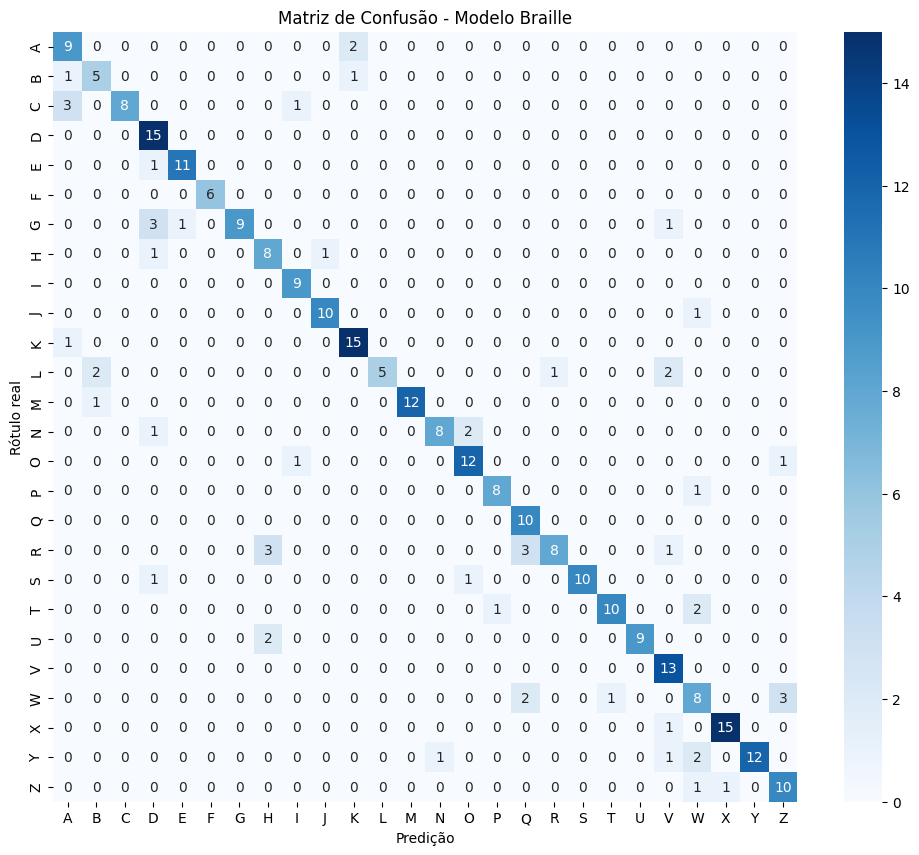

In [ ]:
# Extrair imagens e rótulos do test_ds
all_images = []
all_labels = []

for images, labels in test_ds:
    all_images.append(images.numpy())
    all_labels.append(labels.numpy())

X_test = np.concatenate(all_images, axis=0)
y_true_labels = np.concatenate(all_labels, axis=0)

# Gerar predições do modelo
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(12, 10))
sns.heatmap(cm,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=CLASSES,
            yticklabels=CLASSES)

plt.xlabel("Predição")
plt.ylabel("Rótulo real")
plt.title("Matriz de Confusão - Modelo Braille")
plt.show()